# Sokoban

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import time
from Sokoban import Sokoban

pygame 2.1.3.dev8 (SDL 2.0.22, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Environment

### Useful Functions

In [3]:
def action_to_symbol(action):
    if action == 0:
        flecha =  '→'
    elif action == 1:
        flecha = '↓'
    elif action == 2:
        flecha = '←'
    elif action == 3:
        flecha = '↑'
    else:
        flecha = ''

    return flecha

def actions_to_string(actions):
    arrows = [action_to_symbol(a) for a in actions]
    return ' '.join(arrows)

In [4]:
env = Sokoban('human', level=3)

env.reset()

for i in range(50):
    if i == 0:
        time.sleep(10)
    action = env.action_space.sample()
    print('{:3} {}'.format(i+1, action_to_symbol(action)))
    obs, _ , terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        print('The game ended at step {}'.format(i+1))
        break

env.close()

  1 ↑
  2 ↑
  3 ↓
  4 ↑
  5 ←
  6 ↑
  7 →
  8 ↑
  9 ←
 10 ↓
 11 →
 12 ↑
 13 ↑
 14 ←
 15 →
 16 ←
 17 →
 18 ↓
 19 ↑
 20 ↑
 21 →
 22 ←
 23 ←
 24 ←
 25 →
 26 ↓
 27 ↑
 28 ↑
 29 →
 30 ←
 31 ←
 32 ↑
 33 →
 34 ←
 35 →
 36 →
 37 →
 38 →
 39 ↓
 40 ↓
 41 →
 42 ↓
 43 ↑
 44 ↑
The game ended at step 44


In [5]:
def try_game(env, policy):

    s, _ = env.reset()

    for i in range(50):
        action = policy[s]
        print('{:3} {}'.format(i+1, action_to_symbol(action)))
        s, _ , terminated, *_ = env.step(action)
        if terminated:
            print('The game ended at step {}'.format(i + 1))
            break
    env.close()

# IMPLEMENTATION

### Q-learning MDP

In [6]:
def choose_action_MDP(values, epsilon):
    if random.random() < epsilon:
        # exploration
        return random.choice(range(len(values)))
    else:
        # explotation
        v = np.argwhere(values == np.amax(values)).flatten()
        if len(v) > 0:
            return random.choice(v)
        else:
            return random.choice(range(len(values)))

In [7]:
def QMDP_learning(env, num_episodes=1000, num_steps=100, alpha=0.05, gamma=0.99, eps_max = 1, eps_min = 0.05, chunk_size=1000):

    Q = np.zeros((20, 20, 20, env.Na))
    best_score_total = num_steps
    best_actions_total = []

    best_score_chunk = num_steps
    best_actions_chunk = []

    epsilon = eps_max
    eps_step = (eps_max - eps_min) / num_episodes

    scores = []
    winnings = []
    step_time = []
    errors = []

    print('        BestEver Best   Mean    % Solved  epsilon')

    t0 = time.time()
    s0 = 0 # count steps
    Q_copy = Q.copy()

    for episode in range(num_episodes):
        score = 0
        actions = []

        s, _ = env.reset()
        al, b1, b2 = s

        new_state = True

        for step in range(num_steps):
            s0 += 1
            
            a = choose_action_MDP(Q[al, b1, b2], epsilon if not new_state else 1)
            new_state = False
            new_s, reward, terminated, won , _ = env.step(a)
            al_, b1_, b2_ = new_s

            score += reward       
            actions.append(a) 

            Q[al, b1, b2, a] = Q[al, b1, b2, a] + alpha * (reward + gamma * np.max(Q[al_, b1_, b2_]) - Q[al, b1, b2, a])
            
            if terminated:
                if won:
                    if step + 1 < best_score_chunk:
                        best_score_chunk = step + 1
                        best_actions_chunk = actions

                        if step + 1 < best_score_total:
                            best_score_total = step + 1
                            best_actions_total = actions
                break
            
            al, b1, b2 = al_, b1_, b2_


        scores.append(score)
        winnings.append(won)
        epsilon -= eps_step if epsilon > eps_min else 0

        if episode % 10 == 9:
            # mean squares error
            error = (np.square(Q - Q_copy)).mean()
            errors.append(error)
            Q_copy = Q.copy()
        
        if episode % chunk_size == chunk_size-1:

            step_time.append(1e3 * (time.time()-t0) / s0)
            t0 = time.time()
            s0 = 0

            if episode < chunk_size:
                to_analyze = scores
                wins = winnings
            else:
                to_analyze = scores[-chunk_size-1:-1]    
                wins = winnings[-chunk_size-1:-1] 
            
            found = sum(wins) / len(wins)
            print('Chunk {:>3}: {:>3} | {:>3} | {:>7.2f} | {:>5.1f}% |  {:.4f}  '.format(episode // chunk_size + 1, best_score_total, best_score_chunk,
                                                                                    np.mean(to_analyze), found * 100, epsilon), actions_to_string(best_actions_chunk))
            
            best_score_chunk = num_steps
            best_actions_chunk = []

    return Q, scores, step_time, errors, best_actions_total

### Q-learning LMDP

In [8]:
def choose_action_LMDP(Q):
    if np.sum(Q) == 0:
        Q = np.ones_like(Q)
    p = Q / np.sum(Q)

    return np.random.choice(len(p), 1, p=p)[0]

In [9]:
def QLMDP_learning(env, num_episodes=10000, num_steps=100, alpha=0.1, eta = 1, chunk_size=1000):

    Q = np.ones((20, 20, 20, env.Na))
    best_score_total = num_steps
    best_actions_total = []

    best_score_chunk = num_steps
    best_actions_chunk = []

    scores = []
    winnings = []
    step_time = []
    errors = []

    print('        BestEver Best   Mean    % Solved')

    t0 = time.time()
    s0 = 0 # count steps
    Q_copy = Q.copy()

    for episode in range(num_episodes):

        score = 0
        actions = []

        s, _ = env.reset()
        al, b1, b2 = s

        for step in range(num_steps):
            s0 += 1
            
            a = choose_action_LMDP(Q[al, b1, b2])
            new_s, reward, terminated, won , _ = env.step(a)
            al_, b1_, b2_ = new_s

            score += reward       
            actions.append(a)

            Q[al, b1, b2, a] = (1 - alpha) * Q[al, b1, b2, a] + alpha / env.Na * np.exp(eta * reward) * np.sum(Q[al_, b1_, b2_])

            if terminated:
                if won:
                    if step + 1 < best_score_chunk:
                        best_score_chunk = step + 1
                        best_actions_chunk = actions

                        if step + 1 < best_score_total:
                            best_score_total = step + 1
                            best_actions_total = actions
                break
            
            al, b1, b2 = al_, b1_, b2_

            
        scores.append(score)
        winnings.append(won)

        if episode % 10 == 9:
            # mean squares error
            error = (np.square(Q - Q_copy)).mean()
            errors.append(error)
            Q_copy = Q.copy()
        
        if episode % chunk_size == chunk_size-1:

            step_time.append(1e3 * (time.time()-t0) / s0)
            t0 = time.time()
            s0 = 0

            if episode < chunk_size:
                to_analyze = scores
                wins = winnings
            else:
                to_analyze = scores[-chunk_size-1:-1]    
                wins = winnings[-chunk_size-1:-1] 
            
            found = sum(wins) / len(wins)
            print('Chunk {:>3}: {:>3} | {:>3} | {:>7.2f} | {:>5.1f}%   '.format(episode // chunk_size + 1, best_score_total, best_score_chunk,
                                                                                    np.mean(to_analyze), found * 100), actions_to_string(best_actions_chunk))
            
            best_score_chunk = num_steps
            best_actions_chunk = []

    return Q, scores, step_time, errors, best_actions_total

### Z-learning LMDP

In [10]:
def state_compression(a, b1, b2):
    sc = a * 20 + b1
    sc = sc * 20 + b2
    return sc

def state_decompression(sc):
    b2 = sc % 20
    sc = sc // 20
    b1 = sc % 20
    a = sc // 20
    return a, b1, b2

In [11]:
def compute_P(env):
    P = np.zeros((env.Ns, env.Ns))
    for s in env.states:
        for a in env.actions:
            s_ = env.move(s, a)
            P[state_compression(*s), state_compression(*s_)] = 1
    
    # normalize
    for s in env.states:
        P[state_compression(*s)] = P[state_compression(*s)] / P[state_compression(*s)].sum()
    return P

In [12]:
def compute_next_states(env, s):
    new_states = []
    for a in env.actions:
        s_ = env.move(s, a)
        new_states.append(state_compression(*s_))
    P = {i: 1 / len(new_states) for i in new_states}
    return P

In [13]:
def Z_learning(env, num_episodes=10000, num_steps=100, alpha=0.1, eta=1, chunk_size=1000):

    P = compute_P(env)
    Z = np.ones(20**3)

    best_score_total = num_steps
    best_actions_total = []

    best_score_chunk = num_steps
    best_actions_chunk = []

    scores = []
    winnings = []
    step_time = []
    errors = []

    print('        BestEver Best   Mean    % Solved')

    t0 = time.time()
    s0 = 0 # count steps
    Z_copy = Z.copy()

    for episode in range(num_episodes):

        score = 0
        actions = []

        s, _ = env.reset()

        for step in range(num_steps):
            s0 += 1

            sc = state_compression(*s)

            ZP = P[sc] * Z
            new_sc = choose_action_LMDP(ZP)
            new_s = state_decompression(new_sc)

            a, reward, terminated, won, _ = env.step_no_actions(new_s)

            score += reward       
            actions.append(a)

            Z[sc] = (1 - alpha) * Z[sc] + alpha * np.exp(eta * reward) * np.sum(ZP) 

            if terminated:
                if won:
                    if step + 1 < best_score_chunk:
                        best_score_chunk = step + 1
                        best_actions_chunk = actions

                        if step + 1 < best_score_total:
                            best_score_total = step + 1
                            best_actions_total = actions
                
                Z[state_compression(*new_s)] = np.exp(eta * reward)
                break

            s = new_s

        scores.append(score)
        winnings.append(won)
        
        if episode % 10 == 9:
            # mean squares error
            error = (np.square(Z - Z_copy)).mean()
            errors.append(error)
            Z_copy = Z.copy()

        if episode % chunk_size == chunk_size-1:

            step_time.append(1e3 * (time.time()-t0) / s0)
            t0 = time.time()
            s0 = 0

            if episode < chunk_size:
                to_analyze = scores
                wins = winnings
            else:
                to_analyze = scores[-chunk_size-1:-1]    
                wins = winnings[-chunk_size-1:-1] 
            
            found = sum(wins) / len(wins)
            print('Chunk {:>3}: {:>3} | {:>3} | {:>7.2f} | {:>5.1f}%   '.format(episode // chunk_size + 1, best_score_total, best_score_chunk,
                                                                                    np.mean(to_analyze), found * 100), actions_to_string(best_actions_chunk))
            best_score_chunk = num_steps
            best_actions_chunk = []

    return Z, scores, step_time, errors, best_actions_total

In [14]:
def get_action_states(env, s1, s2):
    for a in env.actions:
        s = env.move(s1, a)
        if state_compression(*s) == s2:
            return a
    return None

In [15]:
def try_game_Z(env, policy):

    s, _ = env.reset()

    for i in range(50):
        action = policy[state_compression(*s)]
        print('{:3} {}'.format(i+1, action_to_symbol(action)))
        if action == None:
            print('ERROR')
        s, _ , terminated, *_ = env.step(action)
        if terminated:
            print('The game ended at step {}'.format(i + 1))
            break
    env.close()

# TRAINING

### Level 1

In [16]:
num_episodes = 10000
num_steps = 50

env = Sokoban(level=1)
env_show = Sokoban('human', render_fps=12, level=1)

##### Training

In [17]:
Q_MDP1, scores_QMDP1, time_QMDP1, error_QMDP1,_ = QMDP_learning(env, num_episodes=num_episodes, num_steps=num_steps, alpha=0.1)

        BestEver Best   Mean    % Solved  epsilon
Chunk   1:  15 |  15 | -256.51 |   2.8% |  0.9050   → → ↑ → → ← ← → ↓ ↑ ↓ ← ↓ → ↓
Chunk   2:  12 |  12 | -258.81 |   8.4% |  0.8100   ↓ → → → ← ↑ ↑ → ↑ ↓ ↓ ↓
Chunk   3:  12 |  13 | -225.49 |  27.4% |  0.7150   ↑ → → ↓ → ← ↑ ↑ → ↓ ↓ → ↓
Chunk   4:  10 |  10 | -194.88 |  48.0% |  0.6200   ↑ → → ↑ → ↓ ← ↓ → ↓
Chunk   5:  10 |  11 | -149.66 |  69.1% |  0.5250   → ↓ → → ← ↑ ↑ → ↓ ↓ ↓
Chunk   6:  10 |  10 | -110.49 |  79.8% |  0.4300   → ↑ → ↑ → ↓ ← ↓ → ↓
Chunk   7:   9 |   9 |  -80.06 |  87.7% |  0.3350   → → ↑ → ↓ ← ↓ → ↓
Chunk   8:   9 |   9 |  -68.45 |  90.0% |  0.2400   → → ↑ → ↓ ← ↓ → ↓
Chunk   9:   9 |   9 |  -42.56 |  94.8% |  0.1450   → → ↑ → ↓ ← ↓ → ↓
Chunk  10:   9 |  10 |  -32.70 |  96.5% |  0.0500   ↑ → → ↑ → ↓ ← ↓ → ↓


In [18]:
Q_LMDP1, scores_QLMDP1, time_QLMDP1, error_QLMDP1,_ = QLMDP_learning(env, num_episodes=num_episodes, num_steps=num_steps)

        BestEver Best   Mean    % Solved
Chunk   1:  11 |  11 | -220.69 |  10.9%    → → → ↑ ↑ → ↓ ← ↓ → ↓
Chunk   2:   9 |   9 | -149.12 |  46.6%    → → ↑ → ↓ ← ↓ → ↓
Chunk   3:   9 |   9 |  -80.81 |  73.4%    → → ↑ → ↓ ← ↓ → ↓
Chunk   4:   9 |   9 |  -49.69 |  86.7%    → → ↑ → ↓ ← ↓ → ↓
Chunk   5:   9 |   9 |  -39.20 |  90.0%    → → ↑ → ↓ ← ↓ → ↓
Chunk   6:   9 |   9 |  -32.35 |  93.3%    → → ↑ → ↓ ← ↓ → ↓
Chunk   7:   9 |   9 |  -28.29 |  94.0%    → → ↑ → ↓ ← ↓ → ↓
Chunk   8:   9 |   9 |  -26.16 |  95.5%    → → ↑ → ↓ ← ↓ → ↓
Chunk   9:   9 |   9 |  -28.74 |  94.5%    → → ↑ → ↓ ← ↓ → ↓
Chunk  10:   9 |   9 |  -24.29 |  96.1%    → → ↑ → ↓ ← ↓ → ↓


In [19]:
Z_LMDP1, scores_ZLMDP1, time_ZLMDP1, error_ZLMDP1,_ = Z_learning(env, num_episodes=num_episodes, num_steps=num_steps)

        BestEver Best   Mean    % Solved
Chunk   1:   9 |   9 |  -61.65 |  54.7%    → → ↑ → ↓ ← ↓ → ↓
Chunk   2:   9 |   9 |  -19.19 |  94.4%    → → ↑ → ↓ ← ↓ → ↓
Chunk   3:   9 |   9 |  -16.95 |  97.0%    → → ↑ → ↓ ← ↓ → ↓
Chunk   4:   9 |   9 |  -16.10 |  98.3%    → → ↑ → ↓ ← ↓ → ↓
Chunk   5:   9 |   9 |  -16.28 |  98.4%    → → ↑ → ↓ ← ↓ → ↓
Chunk   6:   9 |   9 |  -15.76 |  98.7%    → → ↑ → ↓ ← ↓ → ↓
Chunk   7:   9 |   9 |  -16.06 |  98.6%    → → ↑ → ↓ ← ↓ → ↓
Chunk   8:   9 |   9 |  -15.85 |  99.4%    → → ↑ → ↓ ← ↓ → ↓
Chunk   9:   9 |   9 |  -15.94 |  99.4%    → → ↑ → ↓ ← ↓ → ↓
Chunk  10:   9 |   9 |  -15.65 |  99.0%    → → ↑ → ↓ ← ↓ → ↓


##### Policy

In [20]:
# Q-learning MPD
policy_QMDP = np.argmax(Q_MDP1, axis=3)
try_game(env_show, policy_QMDP)

# Q-learning LMPD
policy_QLMDP = np.argmax(Q_LMDP1, axis=3)
try_game(env_show, policy_QLMDP)

# Z-learning lMPD
P = compute_P(env)
policy_next_states = np.argmax(Z_LMDP1 * P, axis=1)
policy = [get_action_states(env, s, s_) for s, s_ in zip(env.states, policy_next_states)]
try_game_Z(env_show, policy)

  1 →
  2 →
  3 ↓
  4 →
  5 ←
  6 ↑
  7 ↑
  8 →
  9 ↓
 10 ↓
 11 ↓
The game ended at step 11
  1 →
  2 →
  3 ↑
  4 →
  5 ↓
  6 ←
  7 ↓
  8 →
  9 ↓
The game ended at step 9
  1 →
  2 →
  3 ↑
  4 →
  5 ↓
  6 ←
  7 ↓
  8 →
  9 ↓
The game ended at step 9


### Level 2

In [21]:
num_episodes = 20000
num_steps = 100

env = Sokoban(level=2)
env_show = Sokoban('human', render_fps=12, level=2)

##### Training

In [22]:
Q_MDP2, scores_QMDP2, time_QMDP2, error_QMDP2, _ = QMDP_learning(env, num_episodes=num_episodes, num_steps=num_steps, alpha=0.1)

        BestEver Best   Mean    % Solved  epsilon
Chunk   1:  81 |  81 | -460.67 |   0.3% |  0.9525   → → ↑ ← ↑ → ↓ ← ↓ ← → → → ← ← ↓ → ← ↓ ↓ ↑ ↓ ← ↑ ← ↑ → ↑ ↓ ↓ ↑ ↓ → ↓ ← ↑ ← ↓ ↓ ← ↓ → ↓ ↓ ↓ ← ↑ ← ← ↓ ↑ → ↓ ↑ ↓ ← ↑ ↑ ← ↑ ↑ → ↑ ↓ ↓ ← ← ↓ ← ↓ ← ← → ← → ↓ → → → ↑ ←
Chunk   2:  73 |  73 | -455.51 |   0.3% |  0.9050   → ← ↑ ← ↑ → ← → ↓ ↑ → ↓ ↑ ↑ ↑ ↑ ↑ → ↓ ← ↓ ← ↑ ← → ↑ ← ← ← ↑ ↑ → ↑ ↓ → ↑ ↑ ↓ ↓ → ↑ ↑ ← ↑ ← ↓ ↓ ← ↑ ↑ ← ↓ ← ← ↑ ↓ → ↓ ↑ → ↓ ← → ← → ↓ ↑ ↓ ↓ → → ↑ ←
Chunk   3:  49 |  49 | -448.32 |   1.5% |  0.8575   ← ← → ↑ → → → → ↓ → → ← ↑ ↑ → ↓ ↓ → ← ↓ ← ↓ ↓ ← ↑ ↑ → ← ↑ ← ↑ → ↓ → → ← → ← ↑ ↓ → ↓ → → ↓ → → ↑ ←
Chunk   4:  26 |  26 | -432.37 |   2.7% |  0.8100   ↑ → ↓ ↑ → ↑ ↑ ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↓ ↓ → ↑ ↑ ↓ ↑ ←
Chunk   5:  25 |  25 | -411.29 |   7.6% |  0.7625   ↓ ↑ → → ↑ ↓ ↓ → ← ↑ ↑ → ↓ ↓ ← ↓ ↑ ← → ↓ ↓ → → ↑ ←
Chunk   6:  22 |  22 | -385.35 |  14.1% |  0.7150   ↑ ← → → ↑ → ↑ ↓ ← ↓ → ← ↓ ↓ ← → ↓ → → ↓ ↑ ←
Chunk   7:  22 |  22 | -359.47 |  20.0% |  0.6675   → → ↑ ↑ → ↓ → ← ↓ ↑ ↓ → ← ↓ ↓ → → 

In [23]:
Q_LMDP2, scores_QLMDP2, time_QLMDP2, error_QLMDP2, _ = QLMDP_learning(env, num_episodes=num_episodes, num_steps=num_steps)

        BestEver Best   Mean    % Solved
Chunk   1:  28 |  28 | -390.49 |   1.6%    ← ↑ → ↑ → ↑ → → ↓ ← ↓ → ← ↓ ↓ ↓ ↑ ↓ ↑ ↓ → ↓ ↓ → ↓ → ↑ ←
Chunk   2:  19 |  19 | -354.40 |  12.3%    ↓ ← → → → ← ↑ → ↑ → ↓ ↓ ← ↓ ↓ → → ↑ ←
Chunk   3:  15 |  15 | -313.00 |  30.9%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   4:  15 |  15 | -221.88 |  55.4%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   5:  15 |  15 | -130.85 |  76.5%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   6:  15 |  15 |  -76.77 |  88.4%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   7:  15 |  15 |  -59.72 |  92.1%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   8:  15 |  15 |  -46.05 |  94.5%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   9:  15 |  15 |  -48.42 |  94.0%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk  10:  15 |  15 |  -42.64 |  95.5%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk  11:  15 |  15 |  -41.01 |  95.6%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk  12:  15 |  15 |  -38.75 |  96.5%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk  13:  15 |  15 |  -32.90 |  97.4%    → → ↑ 

In [24]:
Z_LMDP2, scores_ZLMDP2, time_ZLMDP2, error_ZLMDP2, _ = Z_learning(env, num_episodes=num_episodes, num_steps=num_steps)

        BestEver Best   Mean    % Solved
Chunk   1:  15 |  15 | -127.30 |  50.5%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   2:  15 |  15 |  -29.46 |  96.7%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   3:  15 |  15 |  -24.37 |  98.9%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   4:  15 |  15 |  -24.28 |  99.1%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   5:  15 |  15 |  -22.88 |  99.5%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   6:  15 |  15 |  -22.90 |  99.5%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   7:  15 |  15 |  -22.47 |  99.8%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   8:  15 |  15 |  -22.65 |  99.7%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk   9:  15 |  15 |  -22.24 |  99.8%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk  10:  15 |  15 |  -22.74 |  99.6%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk  11:  15 |  15 |  -22.44 |  99.8%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk  12:  15 |  15 |  -22.14 |  99.9%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk  13:  15 |  15 |  -22.89 |  99.6%    → → ↑ → ↓ ← ↓ → ← ↓ ↓ → → ↑ ←
Chunk  14:

##### Policy

In [25]:
# Q-learning MPD
policy_QMDP = np.argmax(Q_MDP2, axis=3)
try_game(env_show, policy_QMDP)

# Q-learning LMPD
policy_QLMDP = np.argmax(Q_LMDP2, axis=3)
try_game(env_show, policy_QLMDP)

# Z-learning lMPD
P = compute_P(env)
policy_next_states = np.argmax(Z_LMDP2 * P, axis=1)
policy = [get_action_states(env, s, s_) for s, s_ in zip(env.states, policy_next_states)]
try_game_Z(env_show, policy)

  1 →
  2 →
  3 ↓
  4 →
  5 ←
  6 ↑
  7 ↑
  8 →
  9 ↓
 10 ↓
 11 ←
 12 ↓
 13 ↓
 14 →
 15 →
 16 ↑
 17 ←
The game ended at step 17
  1 →
  2 →
  3 ↑
  4 →
  5 ↓
  6 ←
  7 ↓
  8 →
  9 ←
 10 ↓
 11 ↓
 12 →
 13 →
 14 ↑
 15 ←
The game ended at step 15
  1 →
  2 →
  3 ↑
  4 →
  5 ↓
  6 ←
  7 ↓
  8 →
  9 ←
 10 ↓
 11 ↓
 12 →
 13 →
 14 ↑
 15 ←
The game ended at step 15


### Level 3

In [26]:
num_episodes = 20000
num_steps = 200

env = Sokoban(level=3)
env_show = Sokoban('human', render_fps=12, level=3)

##### Training

In [27]:
Q_MDP3, scores_QMDP3, time_QMDP3, error_QMDP3, _ = QMDP_learning(env, num_episodes=num_episodes, num_steps=num_steps, alpha=0.1)

        BestEver Best   Mean    % Solved  epsilon
Chunk   1: 200 | 200 | -588.39 |   0.0% |  0.9525   
Chunk   2: 200 | 200 | -575.97 |   0.0% |  0.9050   
Chunk   3: 200 | 200 | -571.75 |   0.0% |  0.8575   
Chunk   4: 200 | 200 | -562.42 |   0.0% |  0.8100   
Chunk   5: 200 | 200 | -561.17 |   0.0% |  0.7625   
Chunk   6: 200 | 200 | -556.90 |   0.0% |  0.7150   
Chunk   7: 139 | 139 | -555.21 |   0.2% |  0.6675   ↑ ↓ ← ↓ ↓ → → → ← ↑ ↓ ↓ → ↑ → → ← ← → → ↑ → ← ← ↓ ← → → ↑ ↓ ↓ → ↓ ↓ ↑ ← ↓ ← ← ← ↑ ← ↑ ↑ → ← ↑ ↑ ↓ → ↑ ← ↑ → → ↓ ↑ ↑ ↓ ↑ ← ↓ ↑ ↑ → → ↑ ↓ ↓ ← ← ↑ ← → ↑ ↓ ↑ → ← ↓ ← ↑ ↓ ↓ → ← ↓ ← ↑ ↑ → ← ← ↓ ↓ → → ↓ ↑ ↑ ← ↑ ↑ ↓ ← → ← ↓ → ↓ ← ↓ ↑ ↓ → ↑ ← ← ↓ → ← → ↓ → ← → → → ↑ → ↑ → ↑ ← → ↓ ↑ ↓ ←
Chunk   8:  49 |  49 | -557.91 |   0.3% |  0.6200   ↓ → → ↑ ↑ ↓ ↑ → ↓ ← ↑ ↓ ← ↑ → ↓ ↓ ← ← ↓ → → ↑ ↑ ← ↑ → ← ↓ ← ← ↓ → ← ← ↓ ↓ → → ↑ ↑ → → ↓ ↓ ↓ → ↑ ←
Chunk   9:  49 |  61 | -558.88 |   0.7% |  0.5725   ↑ → → ↑ ↑ → ↓ → ↑ ← ↓ ← ↓ ↑ ← → ← ↑ → ↓ → ↓ ↓ ↓ → ↓ → ↑ ↑ ← → ↓ ← ↓ ← ↑ → ← → ↑ ↑ ↑ ↓ → ← ↓ ↑ ↓ ← ↑ 

In [28]:
Q_LMDP3, scores_QLMDP3, time_QLMDP3, error_QLMDP3, _ = QLMDP_learning(env, num_episodes=num_episodes, num_steps=num_steps)

        BestEver Best   Mean    % Solved
Chunk   1: 200 | 200 | -565.88 |   0.0%    
Chunk   2: 200 | 200 | -569.12 |   0.0%    
Chunk   3: 200 | 200 | -569.51 |   0.0%    
Chunk   4: 200 | 200 | -573.27 |   0.0%    
Chunk   5:  63 |  63 | -573.48 |   0.5%    → → → ↑ → ← ↓ ↑ → ↓ ← ↓ ↓ ↓ ↓ → → ← → ↑ ↑ ↑ ← → → ↑ ↓ ↑ → ↓ ← ← ↓ ← ↑ → ↓ → ↑ ↑ ↑ → ← ↑ ← ↓ ← ↓ ↑ ↑ ← → ← ↓ ↑ → → ← ← ↑ ← ← →
Chunk   6:  63 | 110 | -574.23 |   0.3%    ↑ → → → → → ↑ → ↓ ← ← ← ← ↓ ↓ → ↑ ↓ ↓ → ↑ → → → ↑ ↑ ← ← ↓ ↓ ← ← ← → ← ← ↓ ↓ ↑ ↓ ← ↑ ↓ → ← ↓ ↓ ↑ ← ↓ ← ← → ← ↑ ↑ → → ↓ ↓ → → ↓ ← → ↓ ↑ ↑ ← ↑ ↑ → ↑ ← → → → ↑ ← → ← → → ← ↓ ↓ ← ← ↓ ← → → ← ↓ ↓ ← ↓ ← ← ← → → ↑ ↑ → → → ↓ → ←
Chunk   7:  63 |  65 | -572.47 |   0.8%    → → ↑ → ↓ ↑ ← ↑ ↑ ← ↑ ↓ ↓ ↓ ↓ ↓ → → ↑ ← → ← ↓ ↓ ← ↑ ↑ ↓ ↑ ↓ ↓ ← ↑ ↑ ↑ ↓ → → ↑ ↓ ↑ ↓ ↓ ↓ → → ↑ ← → ← → ↑ ← → ← ↑ ↑ → ↓ ← ↓ ← ← ↑ →
Chunk   8:  42 |  42 | -563.14 |   2.8%    → → ↑ → → ↓ ← ← ↑ → ↓ ↓ ↓ → → ↑ ← ↓ → ↑ ↓ ↑ ↑ → → ← ↓ ↓ ← ↓ ↑ → ↑ ↑ ← ↓ → ← ← ← ↑ →
Chunk   9:  37 |  37 | -561.09 |   4.2%    → → ↑ → 

In [29]:
Z_LMDP3, scores_ZLMDP3, time_ZLMDP3, error_ZLMDP3, _ = Z_learning(env, num_episodes=num_episodes, num_steps=num_steps)

        BestEver Best   Mean    % Solved
Chunk   1:  26 |  26 | -236.54 |  52.8%    → → ↑ ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk   2:  25 |  25 |  -94.68 |  94.5%    → → ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk   3:  25 |  25 |  -50.99 |  99.8%    → → ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk   4:  25 |  25 |  -48.66 |  99.9%    → → ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk   5:  25 |  25 |  -47.67 |  99.8%    → → ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk   6:  25 |  25 |  -46.79 | 100.0%    → → ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk   7:  25 |  25 |  -47.32 |  99.9%    → → ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk   8:  25 |  25 |  -47.03 | 100.0%    → → ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk   9:  25 |  25 |  -46.51 | 100.0%    → → ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk  10:  25 |  25 |  -46.69 | 100.0%    → → ↑ → ↓ ← ↓ ↓ ↓ → → ↑ ↑ ← → ↓ ↓ ← ← ↑ ↑ → → ↓ ←
Chunk  11:  25 |  25 |  -46

##### Policy

In [30]:
# Q-learning MPD
policy_QMDP = np.argmax(Q_MDP3, axis=3)
try_game(env_show, policy_QMDP)

# Q-learning LMPD
policy_QLMDP = np.argmax(Q_LMDP3, axis=3)
try_game(env_show, policy_QLMDP)

# Z-learning lMPD
P = compute_P(env)
policy_next_states = np.argmax(Z_LMDP3 * P, axis=1)
policy = [get_action_states(env, s, s_) for s, s_ in zip(env.states, policy_next_states)]
try_game_Z(env_show, policy)

  1 →
  2 →
  3 ↑
  4 →
  5 ↓
  6 ←
  7 ↓
  8 ↓
  9 ↓
 10 →
 11 →
 12 ↑
 13 ←
 14 →
 15 ↑
 16 ←
 17 ↓
 18 ↓
 19 ←
 20 ↑
 21 →
 22 ↑
 23 ↑
 24 ←
 25 ↓
 26 ←
 27 ←
 28 ↑
 29 →
The game ended at step 29
  1 →
  2 →
  3 ↑
  4 →
  5 ↓
  6 ←
  7 ↓
  8 ↓
  9 ↓
 10 →
 11 →
 12 ↑
 13 ↑
 14 ←
 15 →
 16 ↓
 17 ↓
 18 ←
 19 ←
 20 ↑
 21 ↑
 22 →
 23 →
 24 ↓
 25 ←
The game ended at step 25
  1 →
  2 →
  3 ↑
  4 →
  5 ↓
  6 ←
  7 ↓
  8 ↓
  9 ↓
 10 →
 11 →
 12 ↑
 13 ↑
 14 ←
 15 →
 16 ↓
 17 ↓
 18 ←
 19 ←
 20 ↑
 21 ↑
 22 →
 23 →
 24 ↓
 25 ←
The game ended at step 25


# PLOTS

In [108]:
compare_scores_1 = {'Q MDP': scores_QMDP1,  'Q LMDP': scores_QLMDP1, 'Z LMDP': scores_ZLMDP1}
compare_times_1 = {'Q MDP': time_QMDP1,  'Q LMDP': time_QLMDP1, 'Z LMDP': time_ZLMDP1}
compare_error_1 = {'Q MDP': error_QMDP1,  'Q LMDP': error_QLMDP1, 'Z LMDP': error_ZLMDP1}

compare_scores_2 = {'Q MDP': scores_QMDP2,  'Q LMDP': scores_QLMDP2, 'Z LMDP': scores_ZLMDP2}
compare_times_2 = {'Q MDP': time_QMDP2,  'Q LMDP': time_QLMDP2, 'Z LMDP': time_ZLMDP2}
compare_error_2 = {'Q MDP': error_QMDP2, 'Q LMDP': error_QLMDP2, 'Z LMDP': error_ZLMDP2}

compare_scores_3 = {'Q MDP': scores_QMDP3,  'Q LMDP': scores_QLMDP3, 'Z LMDP': scores_ZLMDP3}
compare_times_3 = {'Q MDP': time_QMDP3,  'Q LMDP': time_QLMDP3, 'Z LMDP': time_ZLMDP3}
compare_error_3 = {'Q MDP': error_QMDP3,  'Q LMDP': error_QLMDP3, 'Z LMDP': error_ZLMDP3}

In [135]:
def compare_mean_scores(data, chunk_size, N=10):

    for name, data in data.items():
        groups = [data[x:min(x+chunk_size, len(data)-1)] for x in range(0, len(data), chunk_size)]
        averages = [np.mean(x) for x in groups]
        smooth = np.convolve(averages, np.ones(N)/N, mode='valid')

        plt.plot(np.arange(0, len(data) - (N-1)*chunk_size, chunk_size), smooth, label=name)

    plt.title('Mean Scores over Training')
    plt.suptitle('Sokoban L3')
    plt.legend()
    plt.ylabel('Scores')
    plt.xlabel('Episodes')
    plt.show()

def compare_step_time(data):
    f, ax = plt.subplots(figsize=(5, 6))
    ax.boxplot(list(data.values()), labels=list(data.keys()), flierprops={'marker': 'o', 'markersize': 0.2})

    plt.ylabel('Time in milliseconds')
    plt.title('Step Time over Training')
    plt.show()

def compare_error(data, chunk_size, N=10):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    colors = {'Q MDP': 'C0',  'Q LMDP': 'C1', 'Z LMDP': 'C2'}

    for name, data in data.items():
        groups = [data[x:min(x+chunk_size, len(data)-1)] for x in range(0, len(data), chunk_size)]
        averages = [np.mean(x) for x in groups]
        smooth = np.convolve(averages, np.ones(N)/N, mode='valid')

        if name == 'Q MDP' or name == 'Q LMDP' or name == 'Z LMDP':
            ax1.plot(np.arange(0, len(data) - (N-1)*chunk_size, chunk_size), smooth, label=name, color=colors[name])
        if name == 'Q LMDP' or name == 'Z LMDP':
            ax2.plot(np.arange(0, len(data) - (N-1)*chunk_size, chunk_size), smooth, label=name, color=colors[name])

    f.suptitle('Sokoban L2 - Error over Training')
    ax1.legend()
    ax2.legend()
    plt.show()

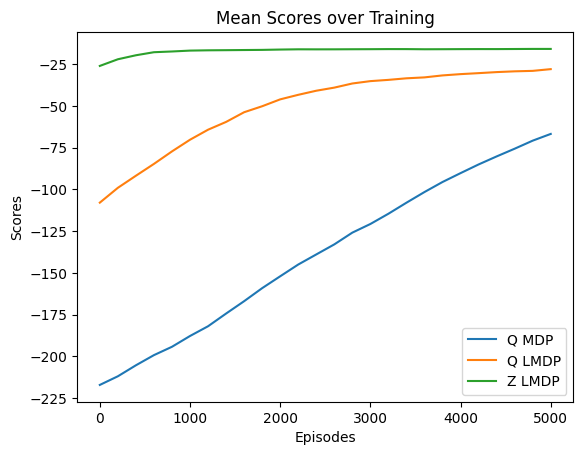

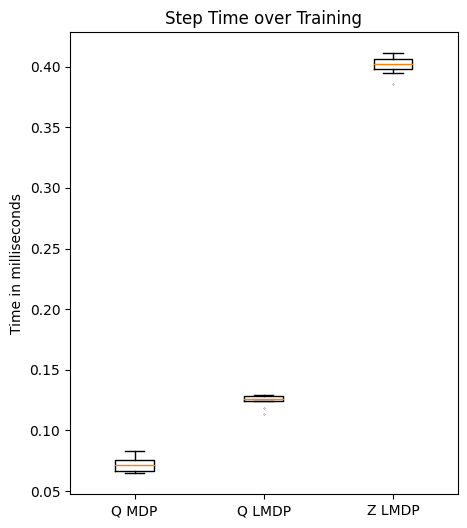

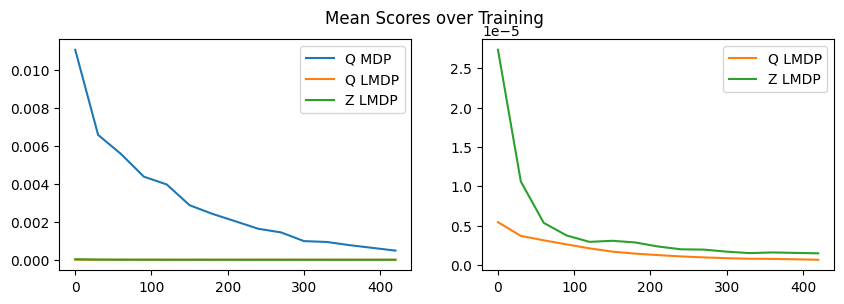

In [104]:
compare_mean_scores(compare_scores_1, 200, N=25)
compare_step_time(compare_times_1)
compare_error(compare_error_1, 30, N=20)

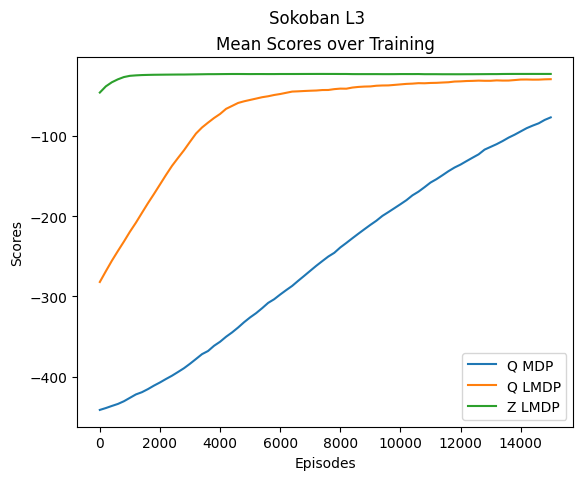

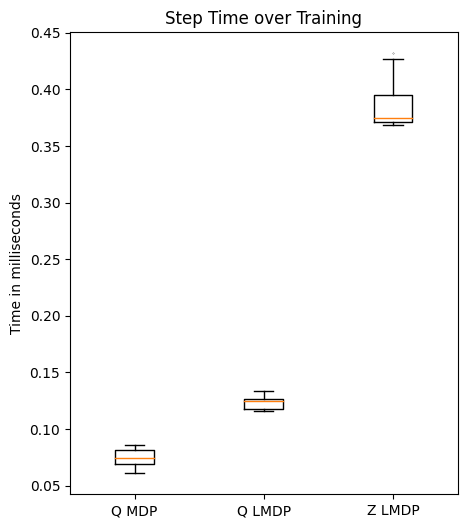

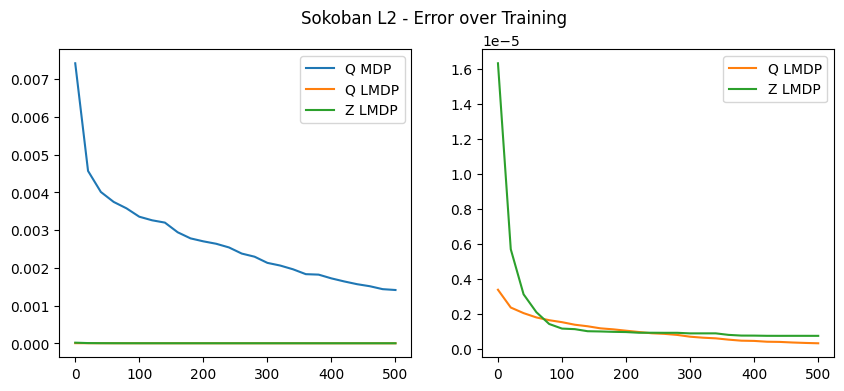

In [136]:
compare_mean_scores(compare_scores_2, 200, N=25)
compare_step_time(compare_times_2)
compare_error(compare_error_2, 20, N=75)

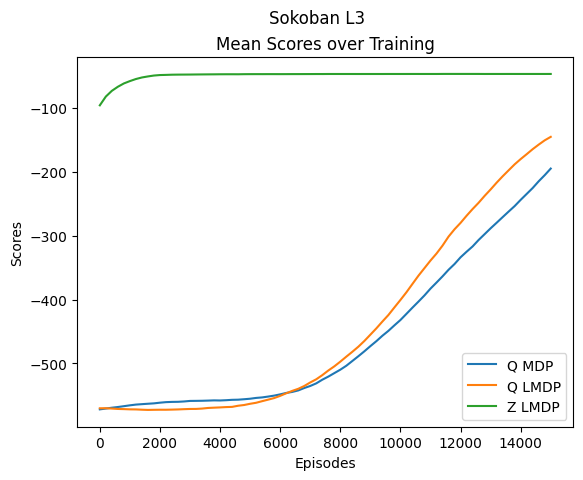

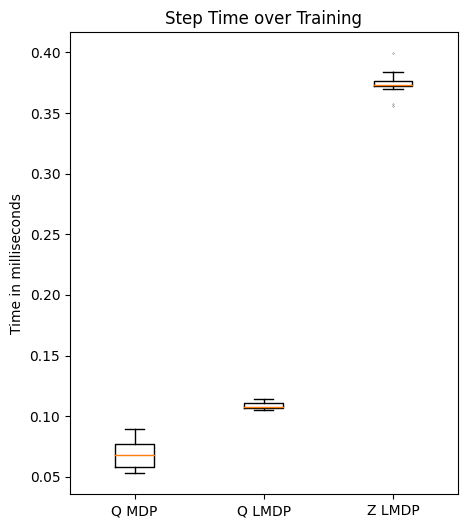

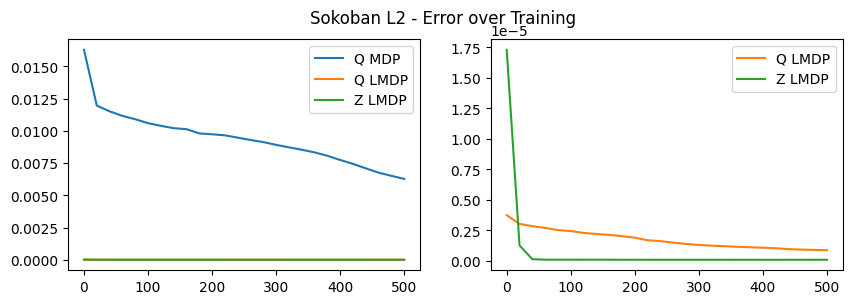

In [133]:
compare_mean_scores(compare_scores_3, 200, N=25)
compare_step_time(compare_times_3)
compare_error(compare_error_3, 20, N=75)